In [27]:
import topiary
import pandas as pd
import numpy as np

### Read BLAST XML and download sequences from NCBI

Topiary generally starts with BLAST results downloaded from the NCBI as XML files. Topiary creates a dataframe from these files and automatically downloads all of the sequences from the NCBI. 

In [28]:
xml_file = "../data/tiny.xml"
f = open(xml_file)
lines = f.readlines()
f.close()

print("NCBI BLAST XML file looks like:\n")
print("".join(lines[:5]))
print("...\n...\n...")
print("".join(lines[-5:]))

NCBI BLAST XML file looks like:

<?xml version="1.0"?>
<!DOCTYPE BlastOutput PUBLIC "-//NCBI//NCBI BlastOutput/EN" "http://www.ncbi.nlm.nih.gov/dtd/NCBI_BlastOutput.dtd">
<BlastOutput>
  <BlastOutput_program>blastp</BlastOutput_program>
  <BlastOutput_version>BLASTP 2.11.0+</BlastOutput_version>

...
...
...
    </Statistics>
  </Iteration_stat>
</Iteration>
</BlastOutput_iterations>
</BlastOutput>



In [29]:
# Load the xml file into a dataframe
df = topiary.ncbi_blast_xml_to_df(xml_file) # <- can specify a list of xml files to load multiple results
df

  0%|          | 0/1 [00:00<?, ?it/s]

Done.


,keep,species,name,sequence,uid,accession,xml,length,evalue,start,end,structure,low_quality,precursor,predicted,isoform,hypothetical,partial,raw_line
0,True,Homo sapiens,lymphocyte antigen 96 isoform 1 precursor,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,hdaxFvgjEP,NP_056179.4,../data/tiny.xml,160,2.539150e-116,0,160,False,False,True,False,True,False,False,ref|NP_056179.4| lymphocyte antigen 96 isoform...
1,True,Pan troglodytes,lymphocyte antigen 96 precursor,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,vBjwWaRffh,NP_001123946.1,../data/tiny.xml,160,4.170520e-115,0,160,False,False,True,False,False,False,False,ref|NP_001123946.1| lymphocyte antigen 96 prec...
2,True,Mus musculus,lymphocyte antigen 96 isoform A precursor,MLPFILFSTLLSPILTESEKQQWFCNSSDAIISYSYCDHLKFPISI...,huwbhuZKWO,NP_058619.1,../data/tiny.xml,160,3.329270e-74,0,160,False,False,True,False,True,False,False,ref|NP_058619.1| lymphocyte antigen 96 isoform...
3,True,Monodelphis domestica,PREDICTED: lymphocyte antigen 96 isoform X1,MLQIVFFSILFTFTFTESMKNDWTCNSQDAEITYSSCDAKKPIPII...,qxHtZhlOKA,XP_007487014.1,../data/tiny.xml,157,7.139460e-52,0,149,False,False,False,True,True,False,False,ref|XP_007487014.1| PREDICTED: lymphocyte anti...
4,True,Sarcophilus harrisii,lymphocyte antigen 96 isoform X1,MLLIMFFSTLFTFTFIESVKNRWTCRTQDTEISYSSCDDKKPIPTI...,zYYoORwGkh,XP_012396711.1,../data/tiny.xml,157,1.218330e-38,16,149,False,False,False,False,True,False,False,ref|XP_012396711.1| lymphocyte antigen 96 isof...
5,True,Gallus gallus,lymphocyte antigen 96 isoform X1,MFEFVLFILFTPGVSGFFCTSSDLELSYTFCDSSAHYFKLNMTPCS...,wmnnCMbOjV,XP_418301.2,../data/tiny.xml,155,8.024920e-20,0,154,False,False,False,False,True,False,False,ref|XP_418301.1| lymphocyte antigen 96 isoform...
6,True,Bos taurus,lymphocyte antigen 96 precursor,MFPFVLFSTLFSSIFTEPRENRWVCNSSDATVWYDYCDNLKFPVSI...,znkkafdBgh,NP_001039982.1,../data/tiny.xml,160,6.976980e-78,0,160,False,False,True,False,False,False,False,ref|NP_001039982.1| lymphocyte antigen 96 prec...
7,True,Loxodonta africana,lymphocyte antigen 96 isoform X1,MFPFVLFSTLFSSIFPEPGEQRWVCNSSDLSVWYTYCDNLKYPILL...,kXEKLwKCJZ,XP_003408398.1,../data/tiny.xml,155,6.184080e-83,0,155,False,False,False,False,True,False,False,ref|XP_003408398.1| lymphocyte antigen 96 isof...
8,True,Xenopus laevis,PREDICTED: lymphocyte antigen 96-like,MEACDFNRLPHVTVEWIPRMDLYQLYGEFVVWYQFSKYSEFSKEFC...,eonnqQUhfT,XP_018120758.1,../data/tiny.xml,88,2.295900e-04,15,69,False,False,False,True,False,False,False,ref|XP_018120758.1| PREDICTED: lymphocyte anti...
9,True,Xenopus laevis,hypothetical protein XELAEV_18033805mg,MEVWYSLCDENDHPIAWIYPCVYDKSKYMNASLTWIPRSDLHHLSV...,eJdbgYyhZX,OCT74818.1,../data/tiny.xml,127,3.860090e-15,2,124,False,False,False,False,False,True,False,gb|OCT74818.1| hypothetical protein XELAEV_180...


### Assign human readable nicknames to sequences
Working with full NCBI names is a pain! Topiary can assign a nickname to each sequence based on user-specified patterns.

In [30]:
alias_dictionary = {"LY96":("lymphocyte antigen 96","MD2","MD-2"),
                    "LY86":("lymphocyte antigen 86","MD1","MD-1")}
df = topiary.create_nicknames(df,aliases=alias_dictionary)
df

,nickname,keep,species,name,sequence,uid,accession,xml,length,evalue,start,end,structure,low_quality,precursor,predicted,isoform,hypothetical,partial,raw_line
0,LY96,True,Homo sapiens,lymphocyte antigen 96 isoform 1 precursor,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,hdaxFvgjEP,NP_056179.4,../data/tiny.xml,160,2.539150e-116,0,160,False,False,True,False,True,False,False,ref|NP_056179.4| lymphocyte antigen 96 isoform...
1,LY96,True,Pan troglodytes,lymphocyte antigen 96 precursor,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,vBjwWaRffh,NP_001123946.1,../data/tiny.xml,160,4.170520e-115,0,160,False,False,True,False,False,False,False,ref|NP_001123946.1| lymphocyte antigen 96 prec...
2,LY96,True,Mus musculus,lymphocyte antigen 96 isoform A precursor,MLPFILFSTLLSPILTESEKQQWFCNSSDAIISYSYCDHLKFPISI...,huwbhuZKWO,NP_058619.1,../data/tiny.xml,160,3.329270e-74,0,160,False,False,True,False,True,False,False,ref|NP_058619.1| lymphocyte antigen 96 isoform...
3,LY96,True,Monodelphis domestica,PREDICTED: lymphocyte antigen 96 isoform X1,MLQIVFFSILFTFTFTESMKNDWTCNSQDAEITYSSCDAKKPIPII...,qxHtZhlOKA,XP_007487014.1,../data/tiny.xml,157,7.139460e-52,0,149,False,False,False,True,True,False,False,ref|XP_007487014.1| PREDICTED: lymphocyte anti...
4,LY96,True,Sarcophilus harrisii,lymphocyte antigen 96 isoform X1,MLLIMFFSTLFTFTFIESVKNRWTCRTQDTEISYSSCDDKKPIPTI...,zYYoORwGkh,XP_012396711.1,../data/tiny.xml,157,1.218330e-38,16,149,False,False,False,False,True,False,False,ref|XP_012396711.1| lymphocyte antigen 96 isof...
5,LY96,True,Gallus gallus,lymphocyte antigen 96 isoform X1,MFEFVLFILFTPGVSGFFCTSSDLELSYTFCDSSAHYFKLNMTPCS...,wmnnCMbOjV,XP_418301.2,../data/tiny.xml,155,8.024920e-20,0,154,False,False,False,False,True,False,False,ref|XP_418301.1| lymphocyte antigen 96 isoform...
6,LY96,True,Bos taurus,lymphocyte antigen 96 precursor,MFPFVLFSTLFSSIFTEPRENRWVCNSSDATVWYDYCDNLKFPVSI...,znkkafdBgh,NP_001039982.1,../data/tiny.xml,160,6.976980e-78,0,160,False,False,True,False,False,False,False,ref|NP_001039982.1| lymphocyte antigen 96 prec...
7,LY96,True,Loxodonta africana,lymphocyte antigen 96 isoform X1,MFPFVLFSTLFSSIFPEPGEQRWVCNSSDLSVWYTYCDNLKYPILL...,kXEKLwKCJZ,XP_003408398.1,../data/tiny.xml,155,6.184080e-83,0,155,False,False,False,False,True,False,False,ref|XP_003408398.1| lymphocyte antigen 96 isof...
8,LY96,True,Xenopus laevis,PREDICTED: lymphocyte antigen 96-like,MEACDFNRLPHVTVEWIPRMDLYQLYGEFVVWYQFSKYSEFSKEFC...,eonnqQUhfT,XP_018120758.1,../data/tiny.xml,88,2.295900e-04,15,69,False,False,False,True,False,False,False,ref|XP_018120758.1| PREDICTED: lymphocyte anti...
9,unassigned,True,Xenopus laevis,hypothetical protein XELAEV_18033805mg,MEVWYSLCDENDHPIAWIYPCVYDKSKYMNASLTWIPRSDLHHLSV...,eJdbgYyhZX,OCT74818.1,../data/tiny.xml,127,3.860090e-15,2,124,False,False,False,False,False,True,False,gb|OCT74818.1| hypothetical protein XELAEV_180...


### Find unique species identifiers from Open Tree of Life

In an ASR project, we usually want to compare our protein tree to a species tree. Using topiary, we can pull down unique taxonomic identifiers (OTTs) and a species tree from the Open Tree of Life database.

In [31]:
df = topiary.get_ott_id(df,phylo_context="Animals")
df.loc[:,["nickname","species","ott","keep"]]

,nickname,species,ott,keep
0,LY96,Homo sapiens,ott770315,True
1,LY96,Pan troglodytes,ott417950,True
2,LY96,Mus musculus,ott542509,True
3,LY96,Monodelphis domestica,ott122362,True
4,LY96,Sarcophilus harrisii,ott948469,True
5,LY96,Gallus gallus,ott153563,True
6,LY96,Bos taurus,ott490099,True
7,LY96,Loxodonta africana,ott541936,True
8,LY96,Xenopus laevis,ott465096,True
9,unassigned,Xenopus laevis,ott465096,True


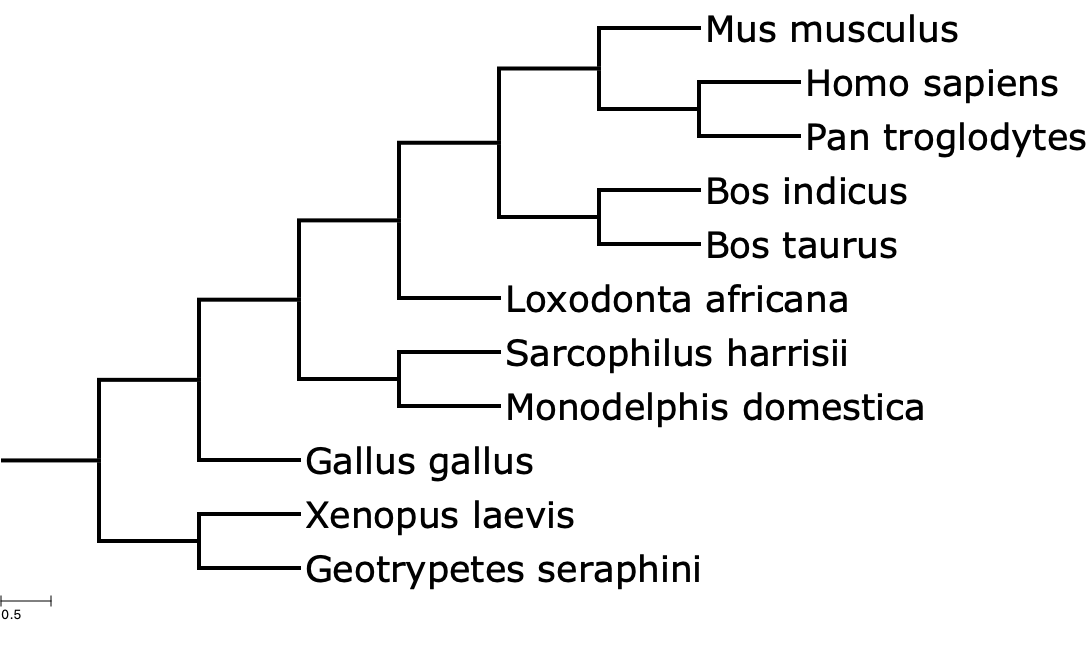

In [32]:
species_tree = topiary.get_species_tree(df)
topiary.draw.species_tree(species_tree,width=100)

### Check sequence identities using reverse BLAST

In [45]:
# Command to blast against NCBI nr database, selecting only human. To search
# based on more one taxid, pass a list of taxid
df = topiary.reverse_blast(df,
                           call_dict={"LY96":["lymphocyte antigen 96","esop1"],
                                      "LY86":"lymphocyte antigen 86"},
                           ncbi_rev_blast_db="nr",taxid=9606)

# Reverse blast against a local database
# df = topiary.reverse_blast(df,
#                            call_dict={"LY96":["lymphocyte antigen 96","esop1"],
#                                       "LY86":["lymphocyte antigen 86"]},
#                            local_rev_blast_db="GRCh38") 

df.loc[:,["nickname","species","reverse_found_paralog","reverse_paralog","keep"]]


Blasting against the NCBI database can be slow/unstable. Consider
creating a local BLAST database for your reverse BLAST needs.

Running NCBI blast against nr.
    Query 1 of 1.
        Attempt 1 of 5.
    Successfully completed query 1 of 1
Done blasting.


,nickname,species,reverse_found_paralog,reverse_paralog,keep
0,LY96,Homo sapiens,True,LY96,True
1,LY96,Pan troglodytes,True,LY96,False
2,LY96,Mus musculus,True,LY96,True
3,LY96,Monodelphis domestica,True,LY86,True
4,LY96,Sarcophilus harrisii,True,LY86,True
5,LY96,Gallus gallus,True,LY86,True
6,LY96,Bos taurus,True,LY86,True
7,LY96,Loxodonta africana,True,LY86,True
8,LY96,Xenopus laevis,True,LY86,True
9,unassigned,Xenopus laevis,True,LY86,False


### Lower redundancy of sequences

In [46]:
# will preferentially keep key species when lowering redundancy
key_species = ["Homo sapiens","Monodelphis domestica"] 
df = topiary.remove_redundancy(df,cutoff=0.85,key_species=key_species)

df.loc[:,["nickname","species","keep"]]

Removing redundant sequences within species.


  0%|          | 0/9 [00:00<?, ?it/s]

Removing redundant sequences, all-on-all.


  0%|          | 0/171 [00:00<?, ?it/s]

Reduced 17 --> 17 sequences.
Done.


,nickname,species,keep
0,LY96,Homo sapiens,True
1,LY96,Pan troglodytes,False
2,LY96,Mus musculus,True
3,LY96,Monodelphis domestica,True
4,LY96,Sarcophilus harrisii,True
5,LY96,Gallus gallus,True
6,LY96,Bos taurus,True
7,LY96,Loxodonta africana,True
8,LY96,Xenopus laevis,True
9,unassigned,Xenopus laevis,False


### Align the sequences using MUSCLE

In [47]:
df = topiary.run_muscle(df)
df.loc[:,["nickname","species","keep","name","alignment"]]


muscle 5.1.osxarm64 [ef62d8-dirty]  17.2Gb RAM, 10 cores
Built Jan 15 2022 11:59:50
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 17 seqs, avg length 152, max 182

00:00 10Mb   CPU has 10 cores, running 10 threads
00:00 11Mb     0.74% Calc posteriors
00:00 37Mb    100.0% Calc posteriors
00:00 37Mb     0.74% Consistency (1/2)
00:00 38Mb    100.0% Consistency (1/2)
00:00 38Mb     0.74% Consistency (2/2)
00:00 38Mb    100.0% Consistency (2/2)
00:00 38Mb      6.2% UPGMA5           
00:00 38Mb    100.0% UPGMA5
00:00 39Mb      1.0% Refining
00:00 40Mb    100.0% Refining

Success. Alignment written to the `alignment` column in the dataframe.


,nickname,species,keep,name,alignment
0,LY96,Homo sapiens,True,lymphocyte antigen 96 isoform 1 precursor,MLPFLFFS---TLFSSIF-----TEAQKQYWVCNSSDASISYTYCD...
1,LY96,Pan troglodytes,False,lymphocyte antigen 96 precursor,<NA>
2,LY96,Mus musculus,True,lymphocyte antigen 96 isoform A precursor,MLPFILFS---TLLSPIL-----TESEKQQWFCNSSDAIISYSYCD...
3,LY96,Monodelphis domestica,True,PREDICTED: lymphocyte antigen 96 isoform X1,MLQIVFFS---ILFTFTF-----TESMKNDWTCNSQDAEITYSSCD...
4,LY96,Sarcophilus harrisii,True,lymphocyte antigen 96 isoform X1,MLLIMFFS---TLFTFTF-----IESVKNRWTCRTQDTEISYSSCD...
5,LY96,Gallus gallus,True,lymphocyte antigen 96 isoform X1,MFEFVLF----ILFT----------PGVSGFFCTSSDLELSYTFCD...
6,LY96,Bos taurus,True,lymphocyte antigen 96 precursor,MFPFVLFS---TLFSSIF-----TEPRENRWVCNSSDATVWYDYCD...
7,LY96,Loxodonta africana,True,lymphocyte antigen 96 isoform X1,MFPFVLFS---TLFSSIF-----PEPGEQRWVCNSSDLSVWYTYCD...
8,LY96,Xenopus laevis,True,PREDICTED: lymphocyte antigen 96-like,M-----------------------------------------EACD...
9,unassigned,Xenopus laevis,False,hypothetical protein XELAEV_18033805mg,<NA>


### Manually edit alignment, then load back into dataframe

<h4>We <span style="color:red">strongly</span> recommend visually inspecting and editing the alignment.</h4> 

To do so, you can load the fasta file written out by muscle into an alignment editor like [AliView](https://ormbunkar.se/aliview/). Once you've done this and saved out a fasta file with the edited alignment, you can load this directly into the topiary dataframe. 

In [48]:
# Write the alignment into a fasta file
topiary.write_fasta(df,"raw-alignment.fasta",seq_column="alignment")

<h4><span style="color:black">EDIT YOUR ALIGNMENT AND SAVE OUT A NEW FASTA FILE</span></h4>

In the cell below, change `manually_edited_fasta_file_name` to be the name of your saved file.

In [49]:
manually_edited_fasta_file_name = "raw-alignment.fasta" # <- change this filename

df = topiary.read_fasta_into(df,manually_edited_fasta_file_name)

df.loc[:,["nickname","species","keep","name","alignment"]]

,nickname,species,keep,name,alignment
0,LY96,Homo sapiens,True,lymphocyte antigen 96 isoform 1 precursor,MLPFLFFS---TLFSSIF-----TEAQKQYWVCNSSDASISYTYCD...
1,LY96,Pan troglodytes,False,lymphocyte antigen 96 precursor,<NA>
2,LY96,Mus musculus,True,lymphocyte antigen 96 isoform A precursor,MLPFILFS---TLLSPIL-----TESEKQQWFCNSSDAIISYSYCD...
3,LY96,Monodelphis domestica,True,PREDICTED: lymphocyte antigen 96 isoform X1,MLQIVFFS---ILFTFTF-----TESMKNDWTCNSQDAEITYSSCD...
4,LY96,Sarcophilus harrisii,True,lymphocyte antigen 96 isoform X1,MLLIMFFS---TLFTFTF-----IESVKNRWTCRTQDTEISYSSCD...
5,LY96,Gallus gallus,True,lymphocyte antigen 96 isoform X1,MFEFVLF----ILFT----------PGVSGFFCTSSDLELSYTFCD...
6,LY96,Bos taurus,True,lymphocyte antigen 96 precursor,MFPFVLFS---TLFSSIF-----TEPRENRWVCNSSDATVWYDYCD...
7,LY96,Loxodonta africana,True,lymphocyte antigen 96 isoform X1,MFPFVLFS---TLFSSIF-----PEPGEQRWVCNSSDLSVWYTYCD...
8,LY96,Xenopus laevis,True,PREDICTED: lymphocyte antigen 96-like,M-----------------------------------------EACD...
9,unassigned,Xenopus laevis,False,hypothetical protein XELAEV_18033805mg,<NA>


In [50]:
#["JTT","LG","WAG","LG4M","LG4X","PROTGTR"]
topiary.find_best_model(df,
                        model_matrices=["JTT","LG"],
                        model_rates=[""],
                        model_freqs=[""],
                        model_invariant=[""],
                        output="find-model",
                        overwrite=True)


Generating maximum parsimony tree.

Running 'raxml-ng --start --msa alignment.phy --model LG --seed 0265597565 --threads 10 --tree pars{1}'

Trying 2 combinations of matrix and model parameters.

JTT (1/2)
Running 'raxml-ng --evaluate --msa alignment.phy --tree tree.newick --model JTT --seed 0410178141 --threads 10'
LG (2/2)
Running 'raxml-ng --evaluate --msa alignment.phy --tree tree.newick --model LG --seed 0410178141 --threads 10'

Top 10 models:

               model           AICc prob
                 JTT               1.000
                  LG               0.000

Wrote results to /Users/harmsm/work/programming/git-clones/asr-protocol/asr-protocol/find-model/output



Running 'raxml-ng --search --msa alignment.phy --model JTT --seed 5763485197 --threads 10'

RAxML-NG v. 1.1.0 released on 29.11.2021 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Apple M1 Pro, 10 cores, 16 GB RAM

RAxML-NG was called at 20-May-2022 13:46:28 as follows:

raxml-ng --search --msa alignment.phy --model JTT --seed 5763485197 --threads 10

Analysis options:
  run mode: ML tree search
  start tree(s): random (10) + parsimony (10)
  random seed: 5763485197
  tip-inner: OFF
  pattern compression: ON
  per-rate scalers: OFF
  site repeats: ON
  fast spr radius: AUTO
  spr subtree cutoff: 1.000000
  branch lengths: proportional (ML estimate, algorithm: NR-FAST)
  SIMD kernels: SSE3
  parallelization: coarse

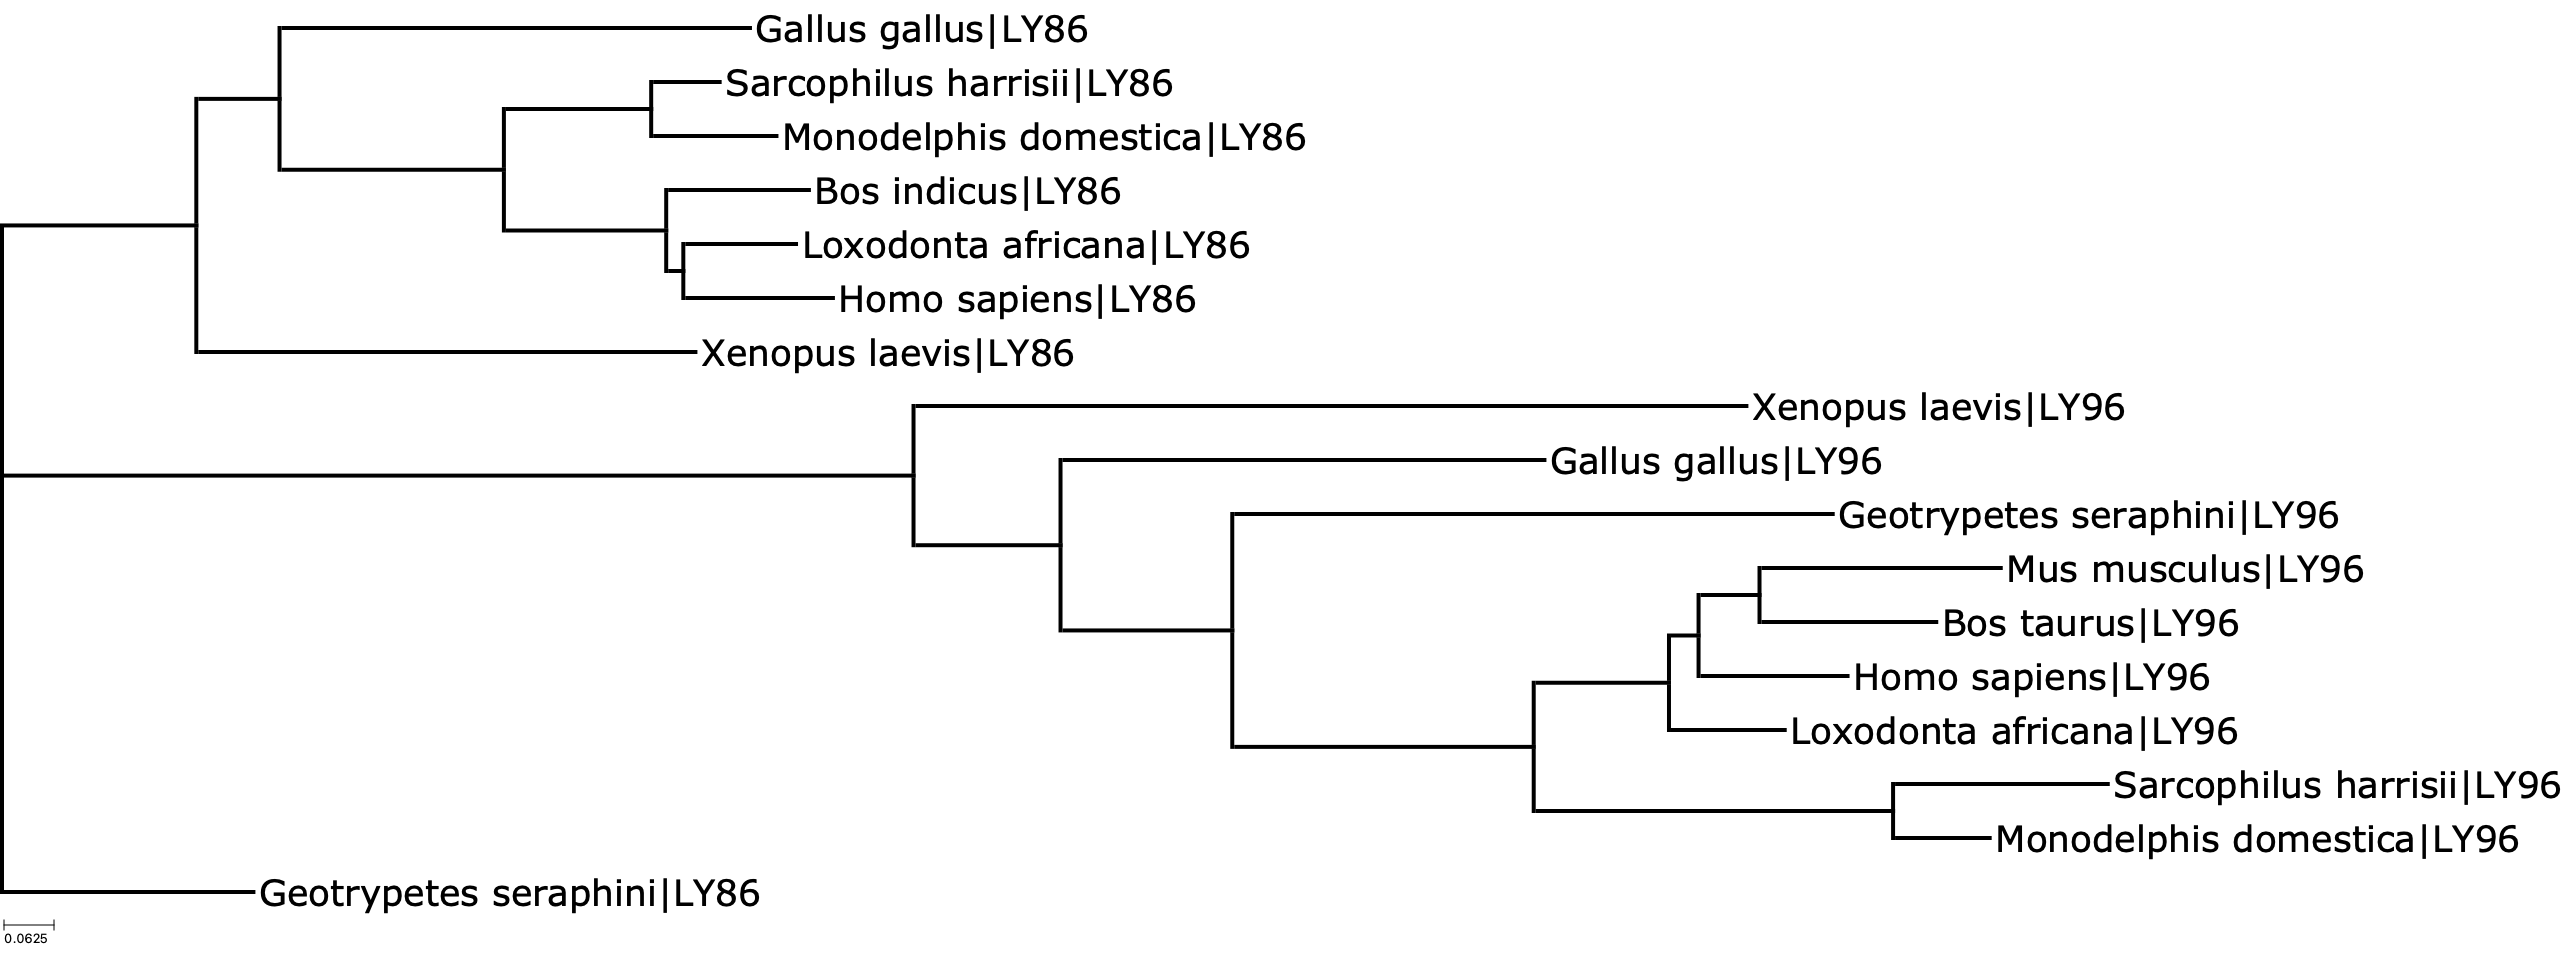

In [51]:
topiary.generate_ml_tree(previous_dir="find-model",
                         output="ml-tree",
                         overwrite=True,bootstrap=False)

Running 'generax --families control.txt --species-tree species_tree.newick --prefix result --rec-model UndatedDL'
GeneRax was called as follow:
generax --families control.txt --species-tree species_tree.newick --prefix result --rec-model UndatedDL 

General information:
- Output prefix: result
- Families information: control.txt
- Species tree: species_tree.newick
- You are running GeneRax without MPI (no parallelization)
- Random seed: 123
- Reconciliation model: UndatedDL
- DTL rates: global rates
- Infer ML reconciliation: ON
- Unrooted reconciliation likelihood: OFF
- Prune species tree mode: OFF

Gene tree correction information:
- Gene tree strategy: SPR
- Max gene SPR radius: 5

[00:00:00] Filtering invalid families...

End of instance initialization
[00:00:00] Starting species tree initialization...
[00:00:00] End of species tree initialization
[00:00:00] Filtering invalid families based on the starting species tree...

[00:00:00] Gathering statistics about the families...
[00:

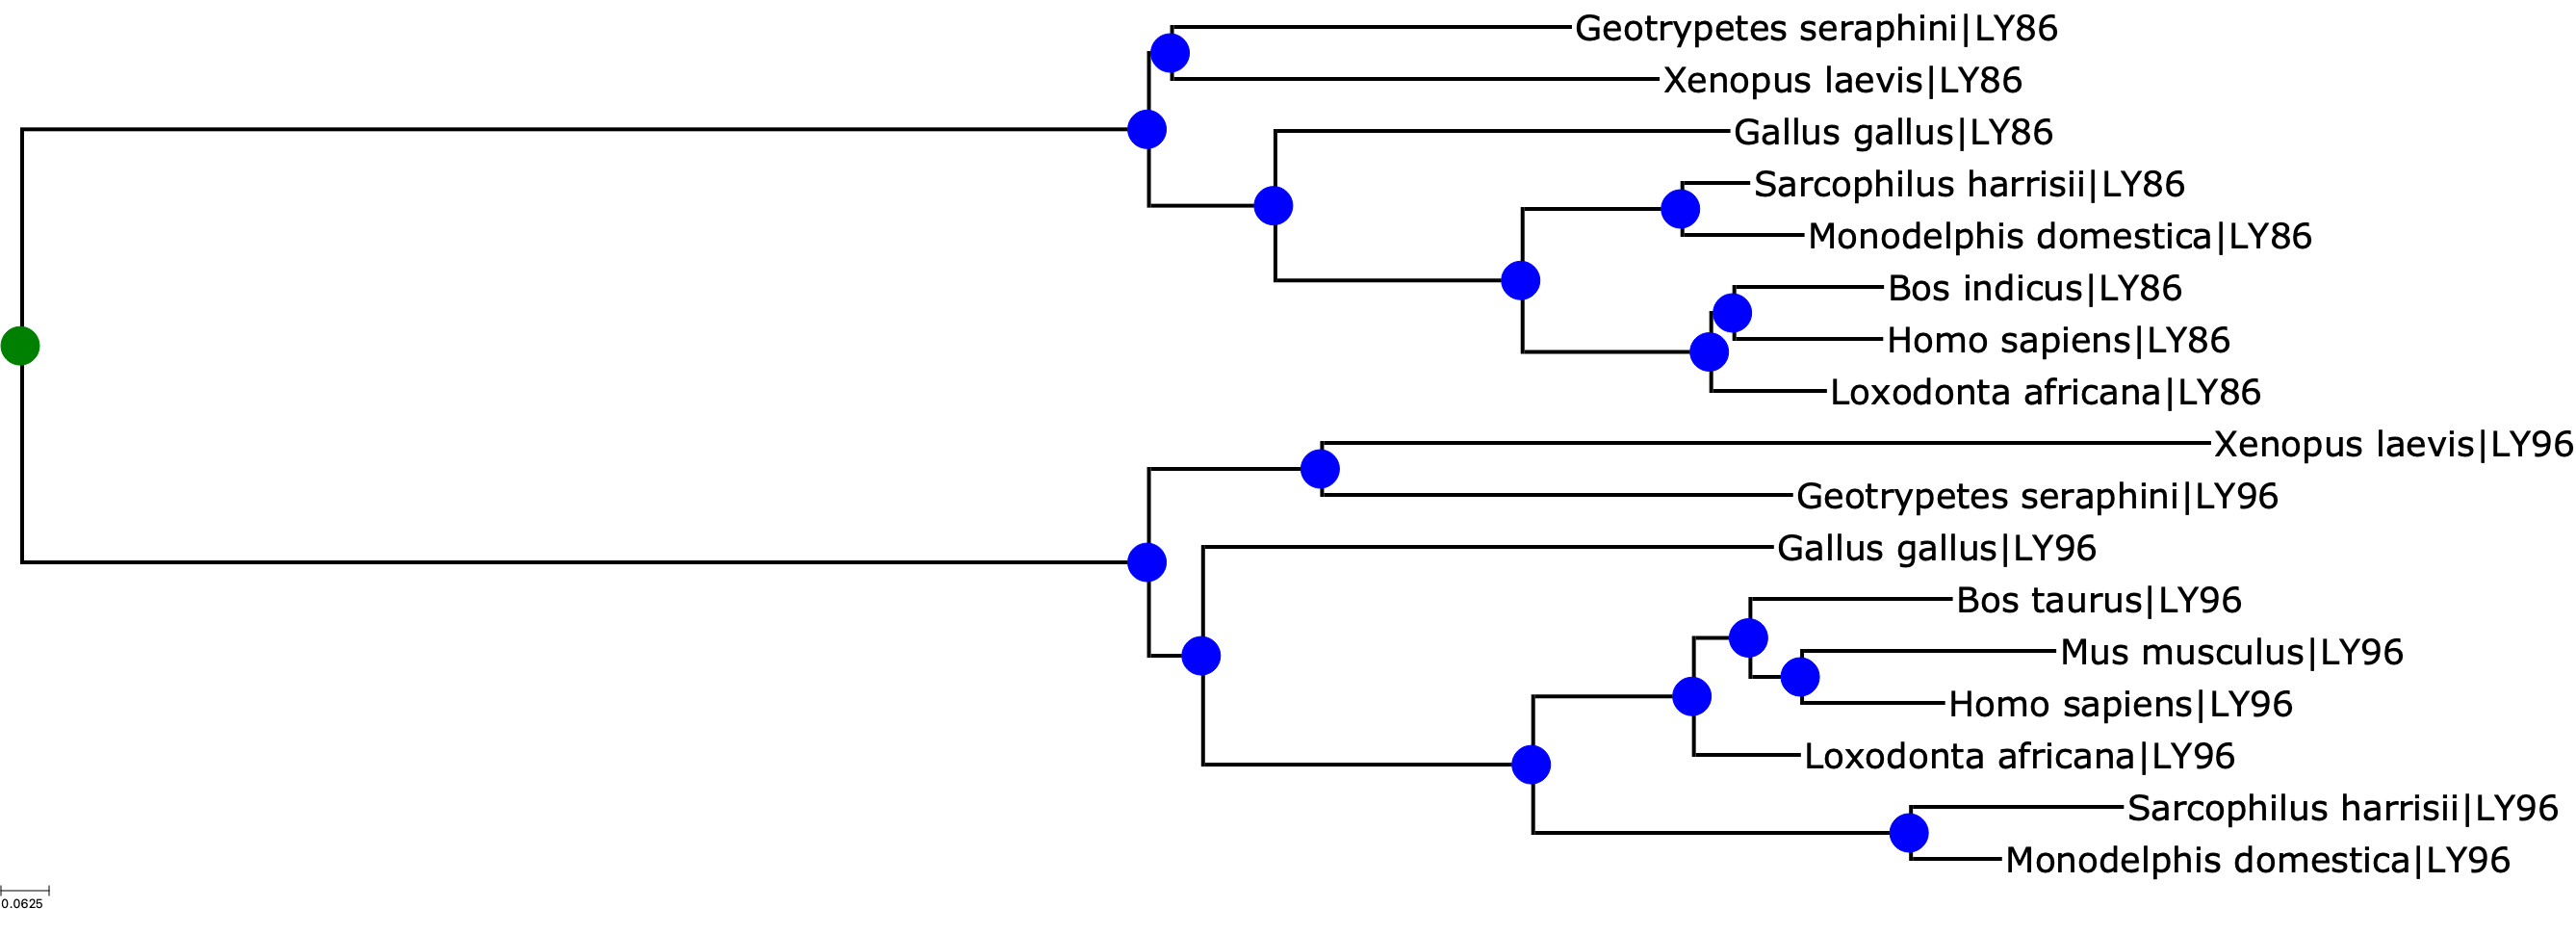

In [52]:
topiary.reconcile(previous_dir="ml-tree",
                  output="reconciled",
                  overwrite=True)

Running 'raxml-ng --ancestral --msa alignment.phy --tree tree.newick --model JTT --seed 9724994105 --threads 10'

Wrote results to /Users/harmsm/work/programming/git-clones/asr-protocol/asr-protocol/ancestors/output

here


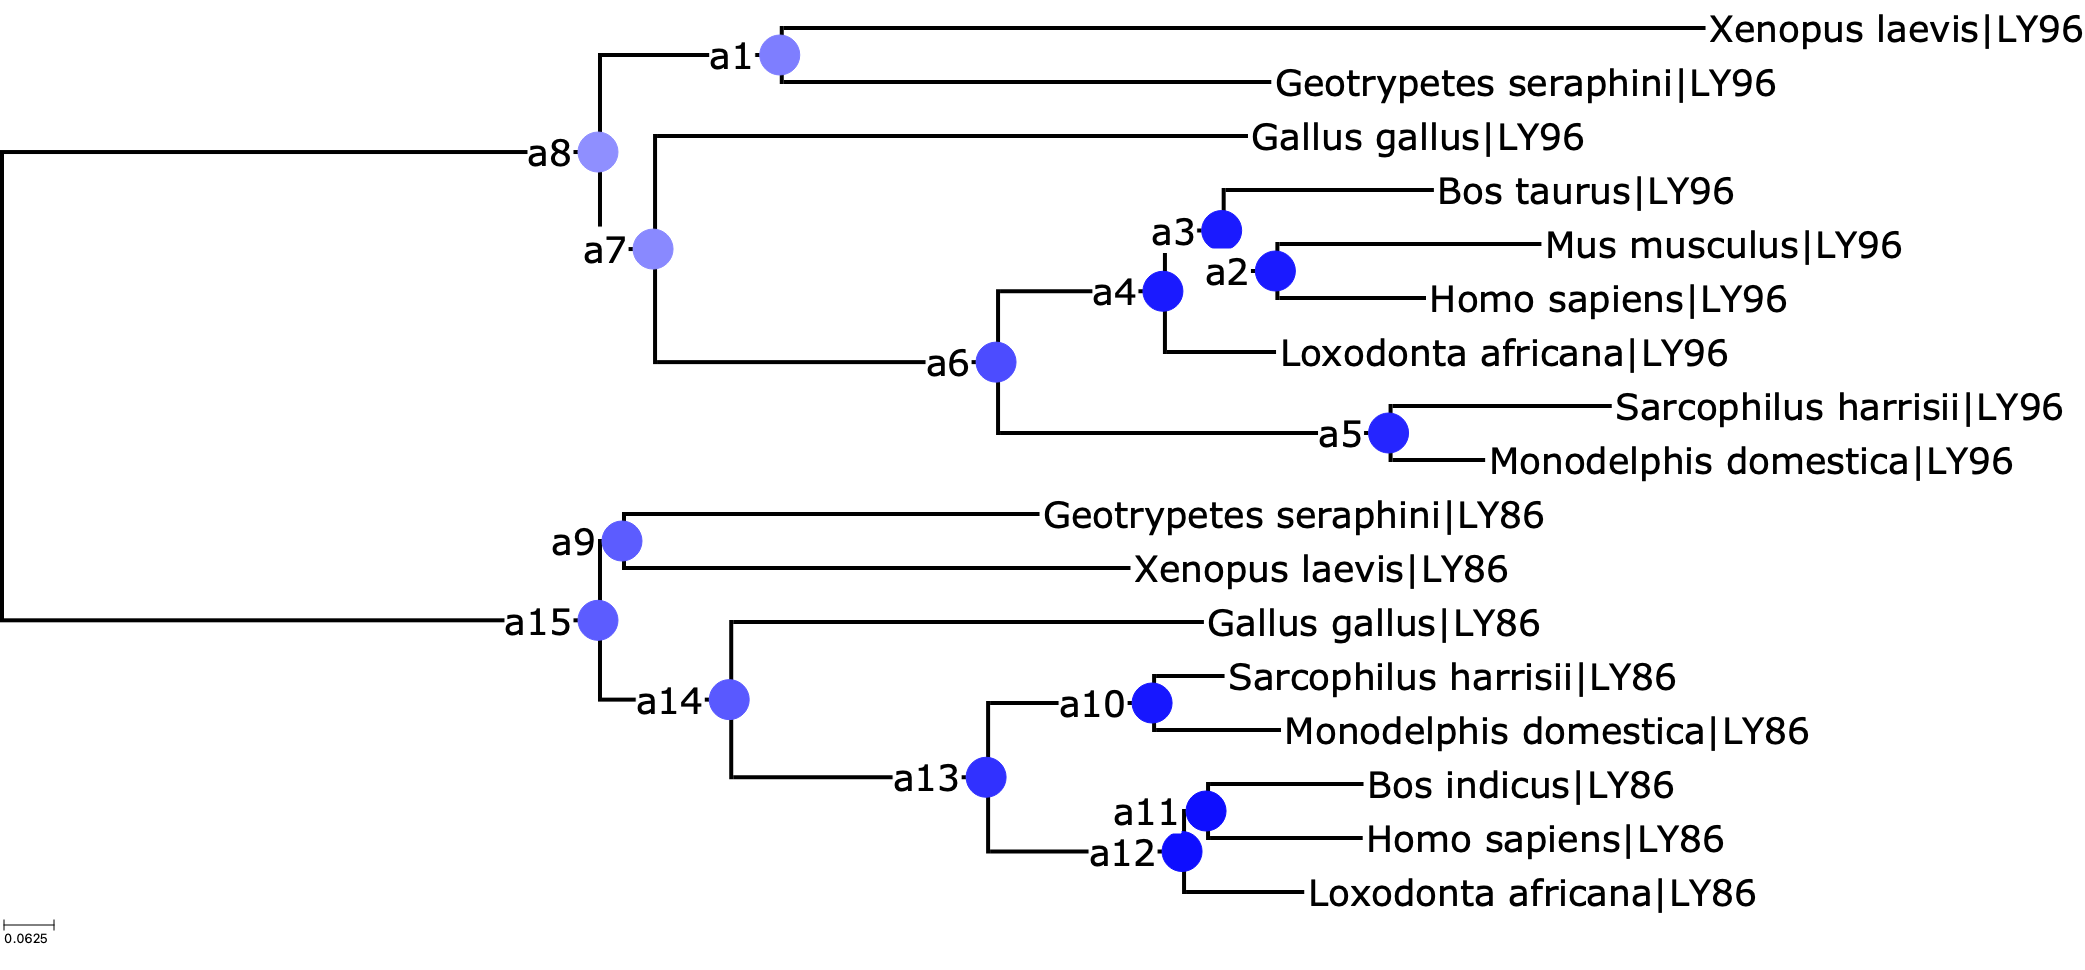

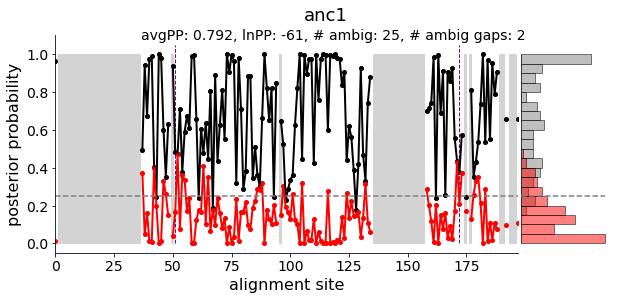

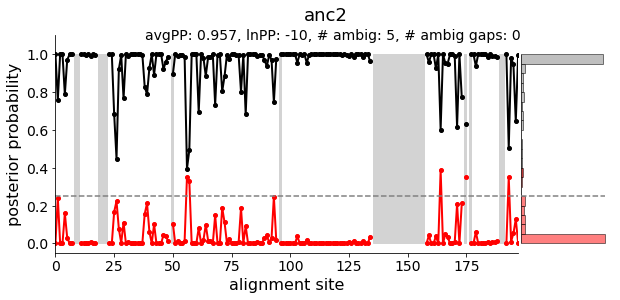

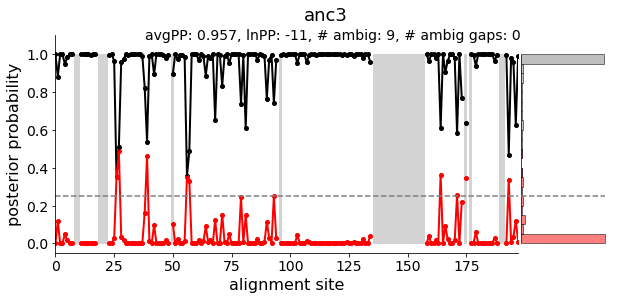

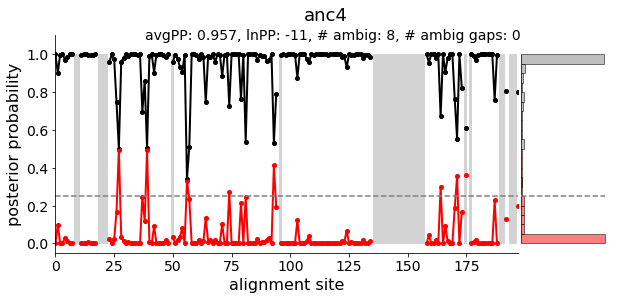

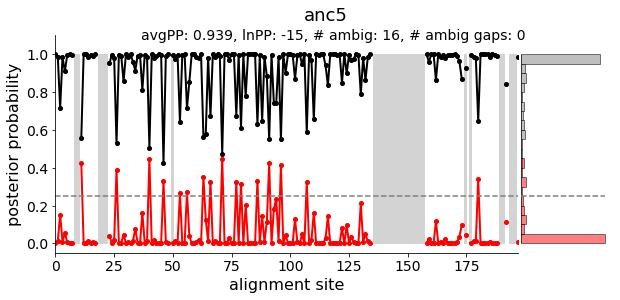

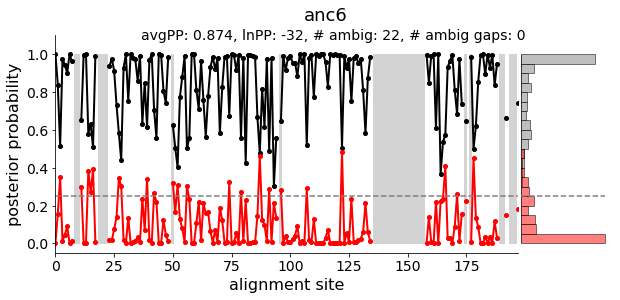

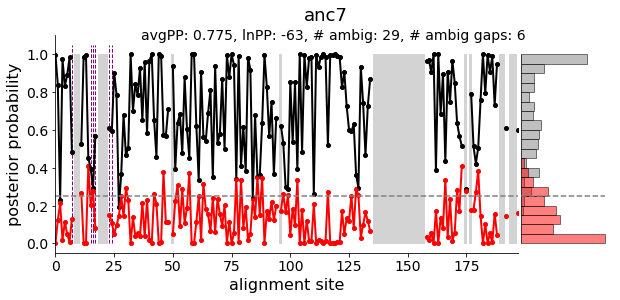

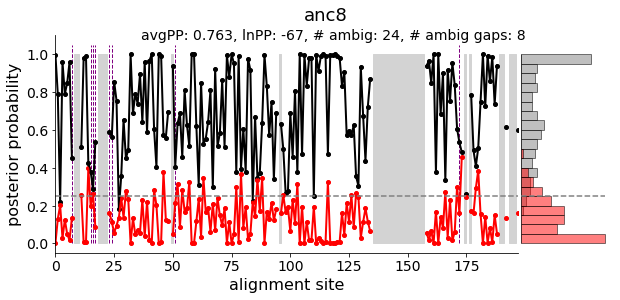

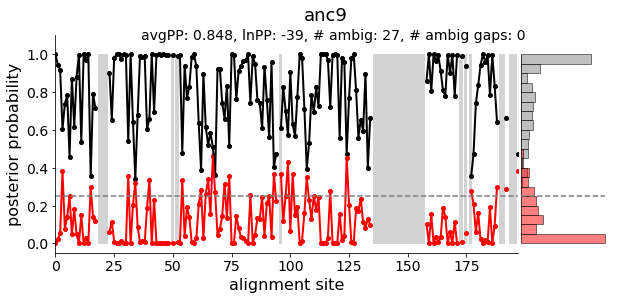

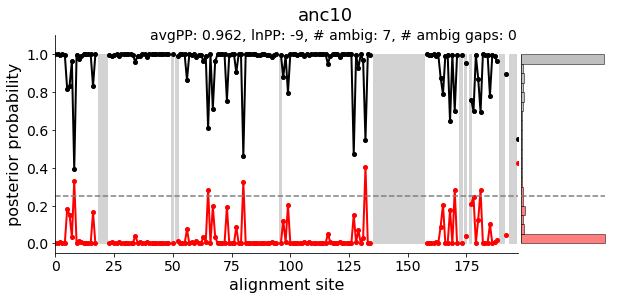

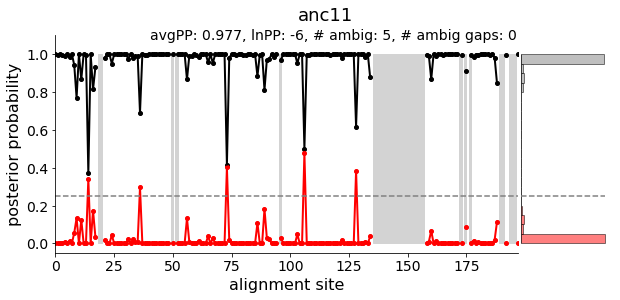

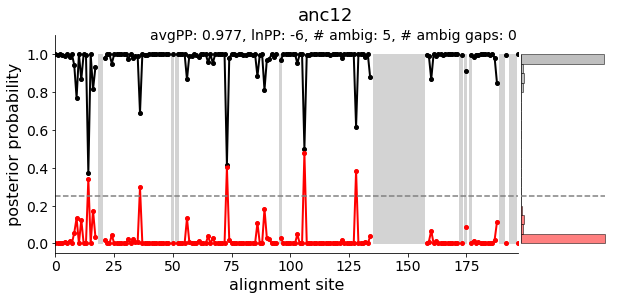

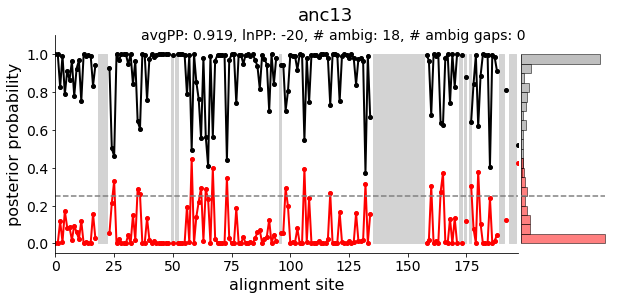

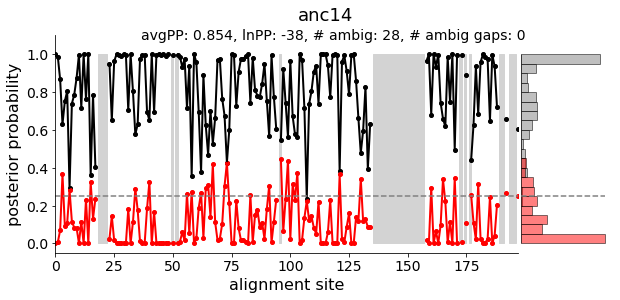

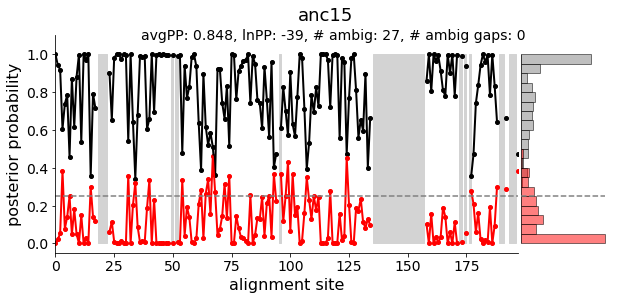

In [53]:
topiary.generate_ancestors(previous_dir="reconciled",
                           output="ancestors",
                           overwrite=True)

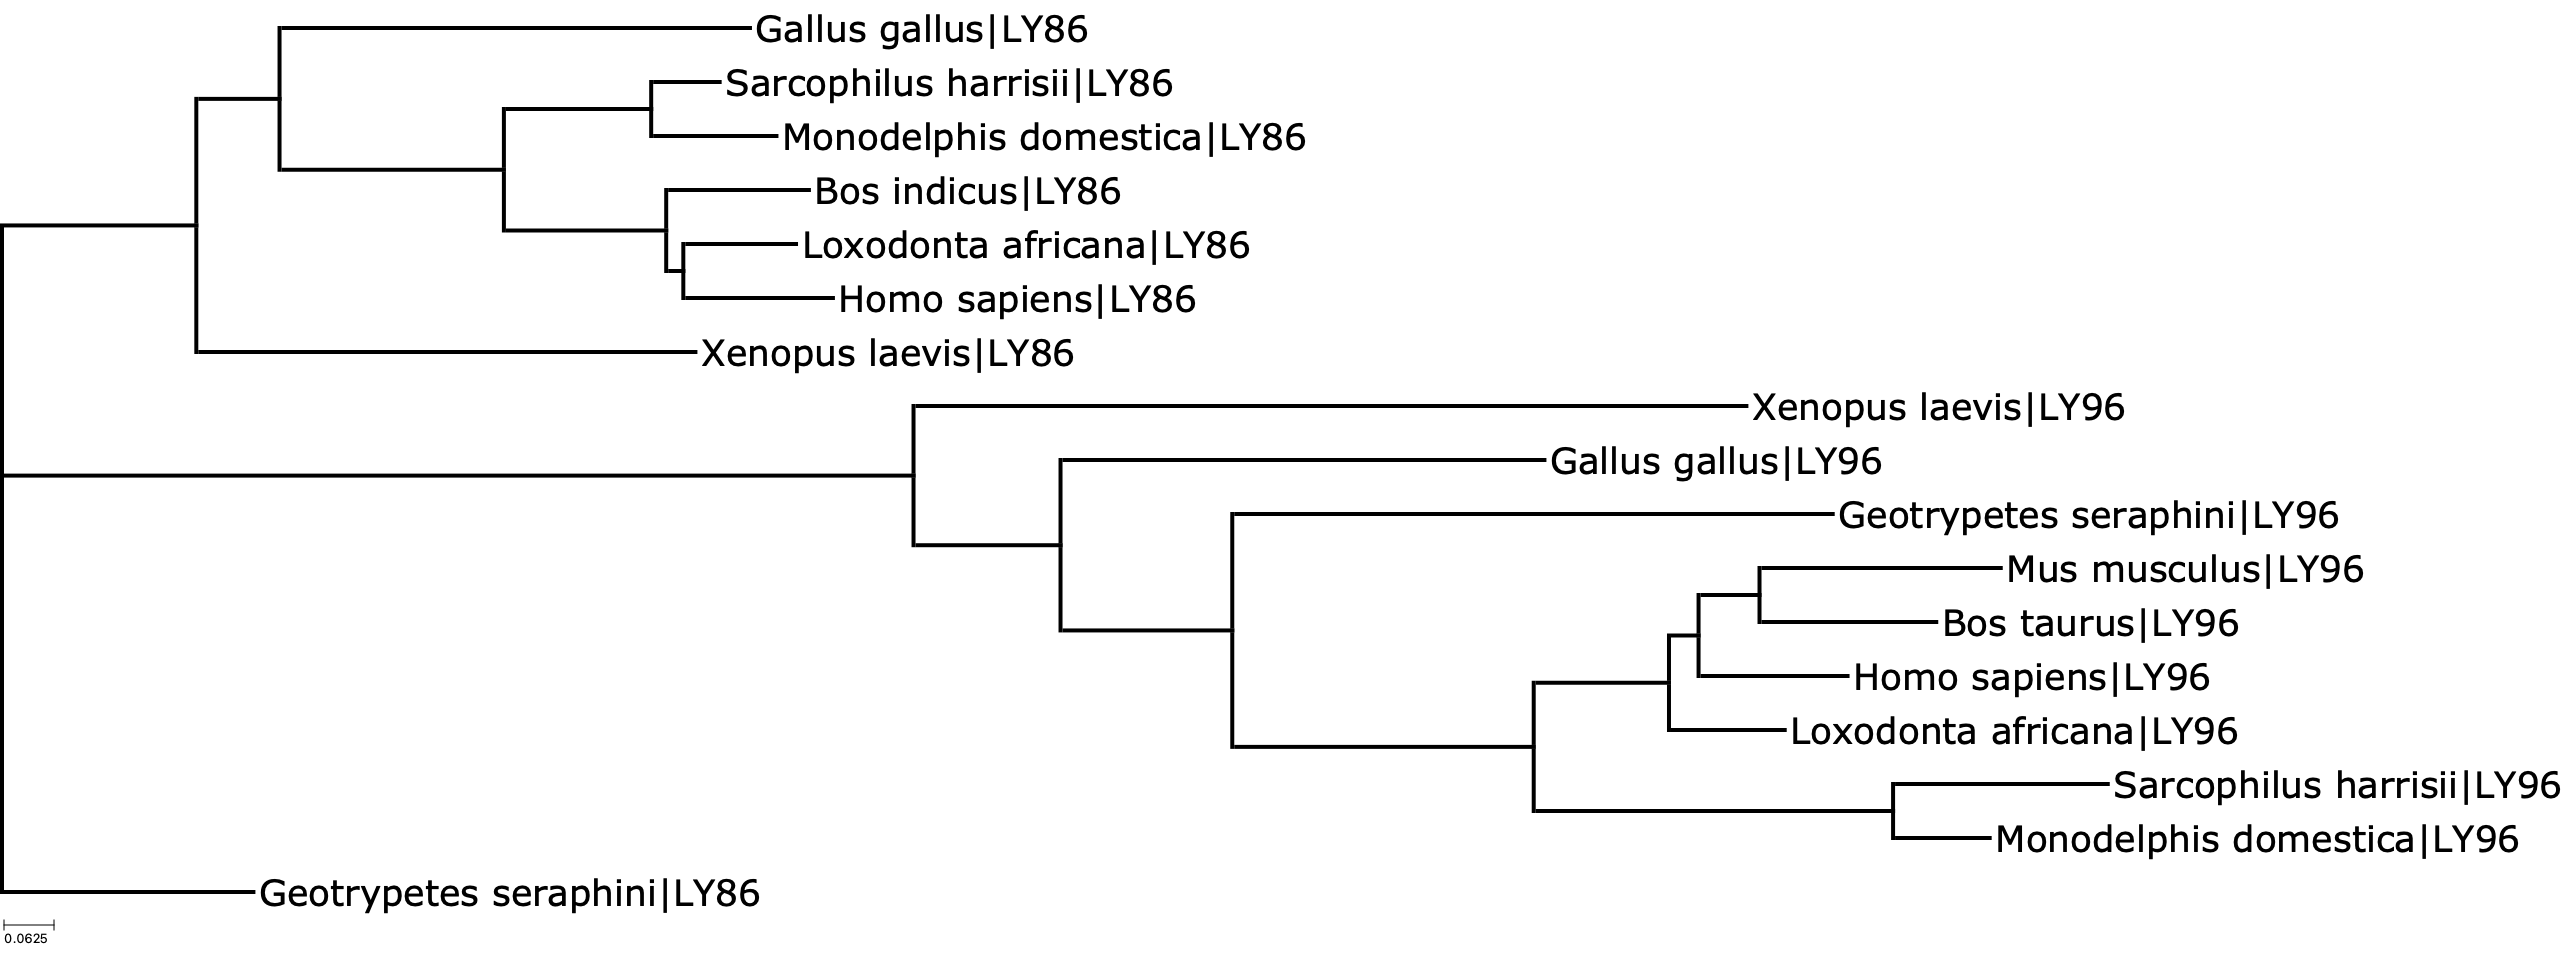

In [54]:
topiary.draw.tree("ml-tree")

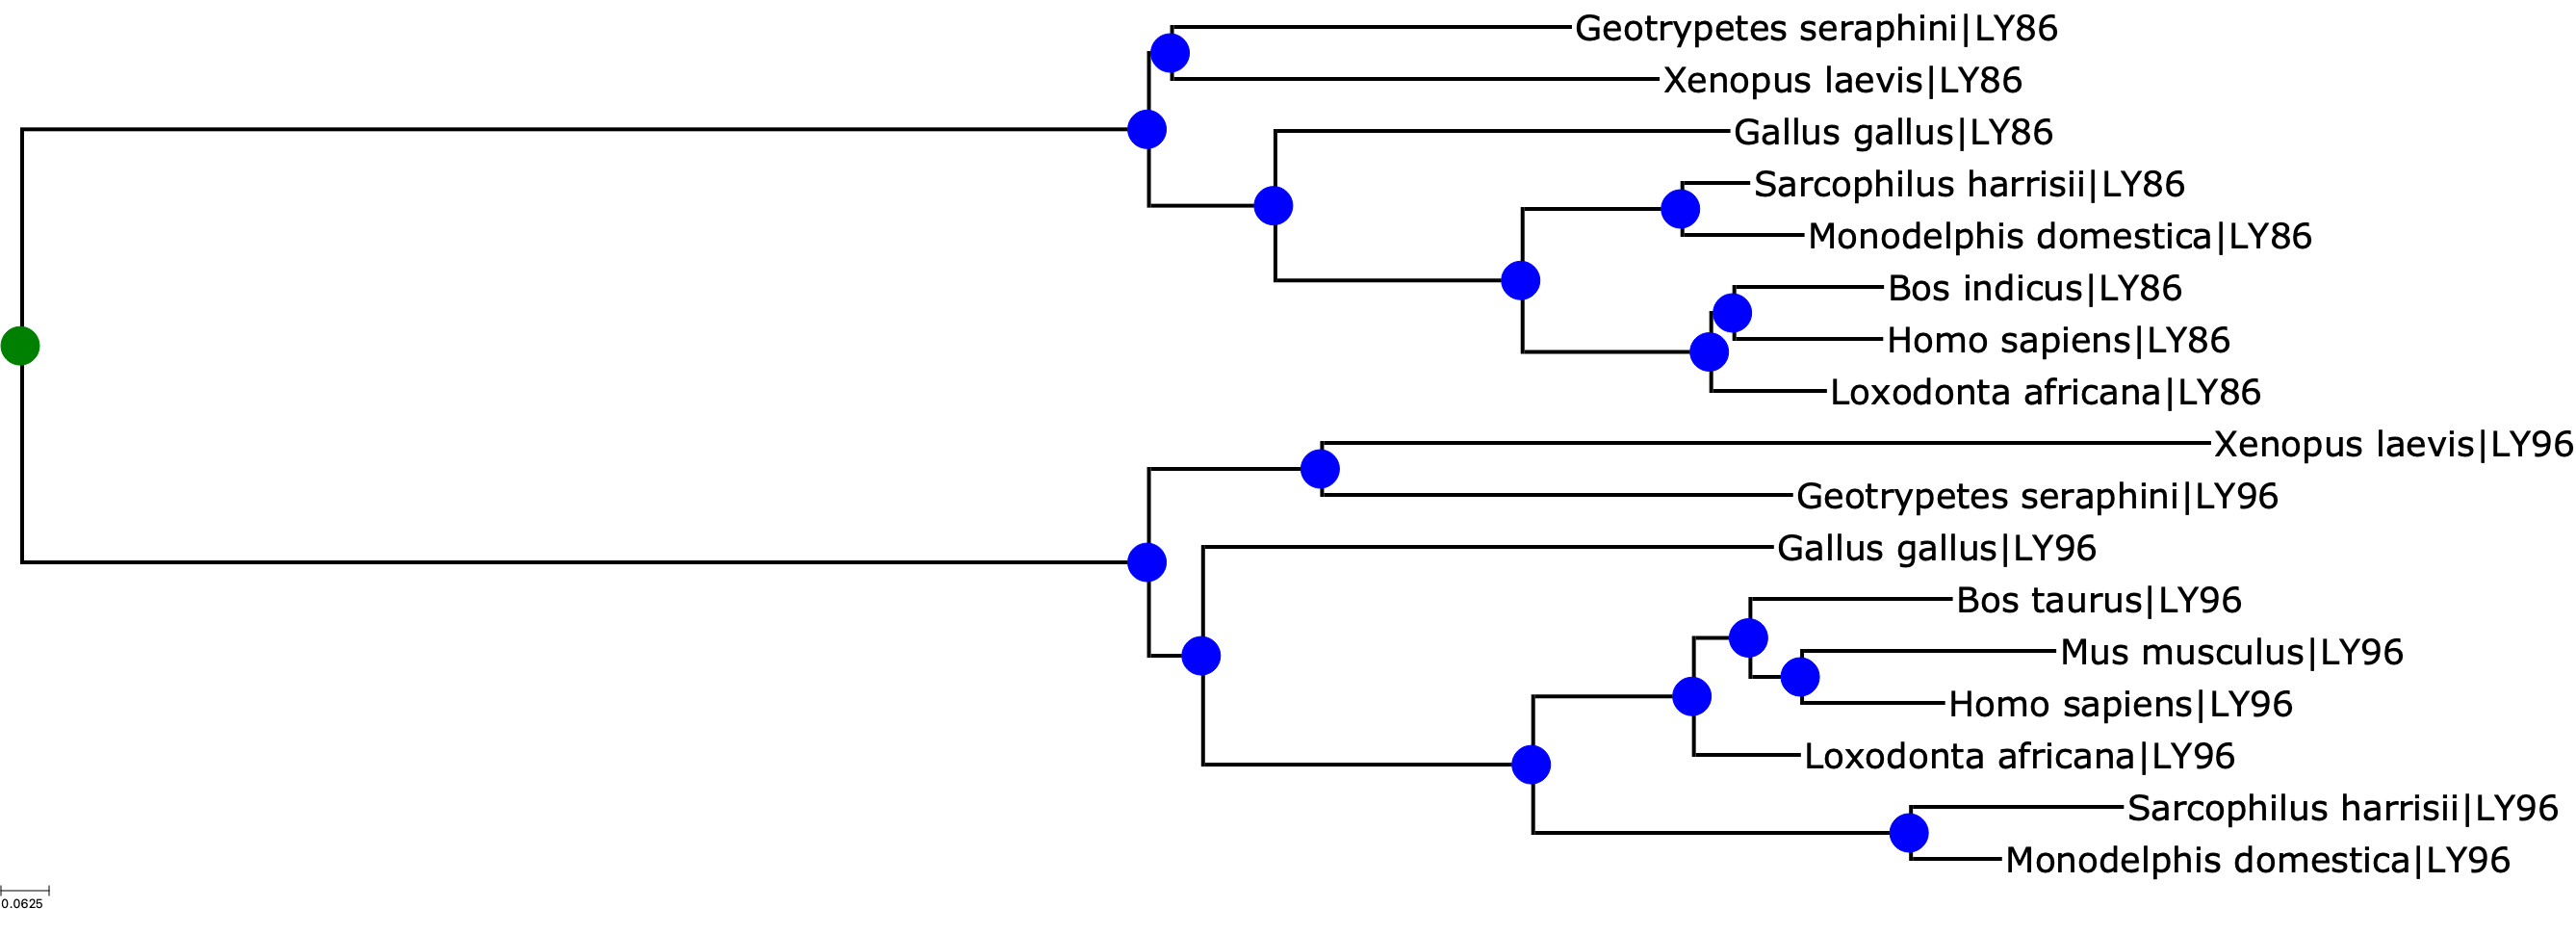

In [55]:
topiary.draw.tree("reconciled/")

here


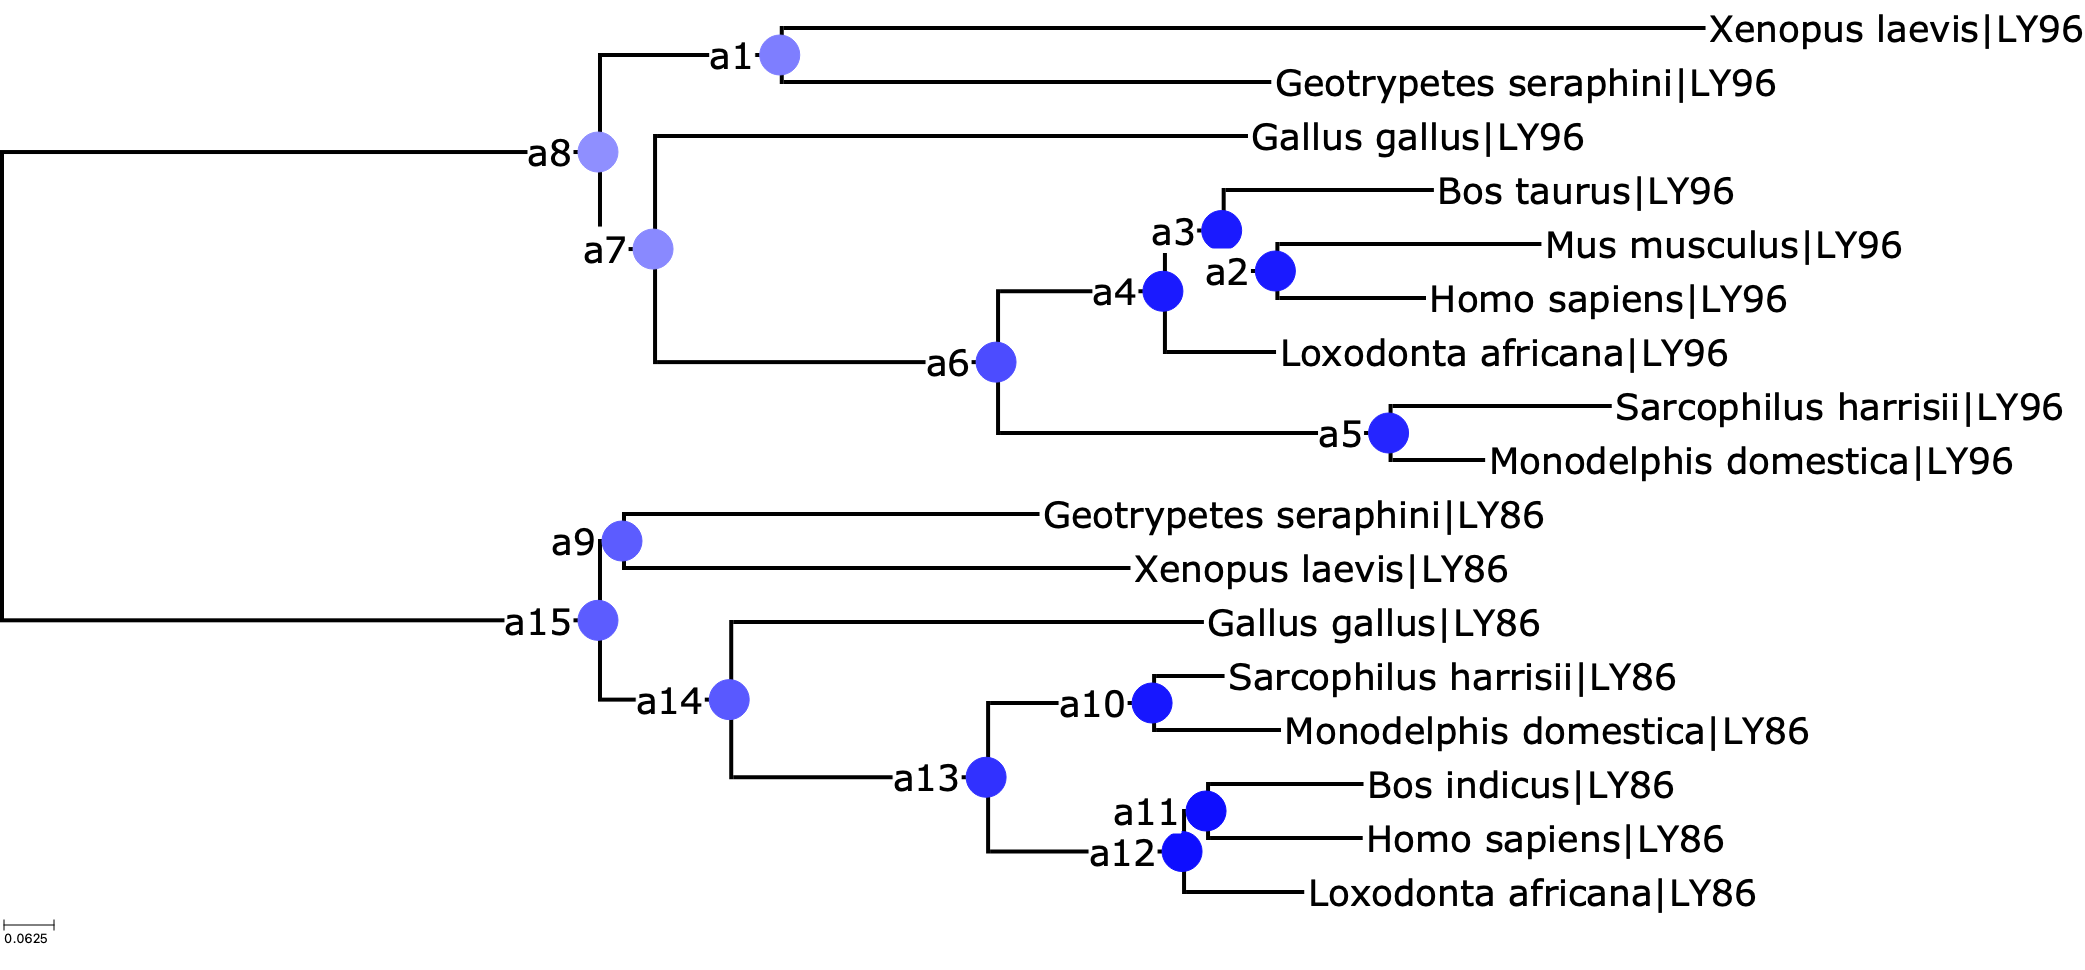

In [56]:
topiary.draw.tree("ancestors/")